 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 5. Machine Learning Basis**
# Section 3. Gradient Descent 방법

### _Objective_
1. 최적의 가중치를 찾는 방법인 Gradient Descent에 대해 배워봅니다. <br>
2. 선형 회귀를 최적화하기 위한 식인 Loss Function에 대해 알아봅니다. <br>
  
╚═════════════════════════════════════════╝

In [159]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt

## 예제 데이터 ) 빅데이터로 예측한 '옥자' 관객 수

"이전까지 개봉했던 영화의 보고싶어요 수와 관객 수를 바탕으로, 옥자의 예상 관객 수 예측하기"

reference : [빅데이터로 예측한 옥자 관객 수 727만 명](http://platum.kr/wp-content/uploads/2017/06/unnamed-12.png)
![](http://platum.kr/wp-content/uploads/2017/06/unnamed-12.png)

In [160]:
movie_df = pd.DataFrame([
    [8759, 487],
    [10132,612],
    [12078,866],
    [16430,1030]],
    columns=["nums_want_to_see","nums_audience"])
movie_df.index = ["마션","킹스맨","캡틴아메리카","인터스텔라"]
movie_df

,nums_want_to_see,nums_audience
마션,8759,487
킹스맨,10132,612
캡틴아메리카,12078,866
인터스텔라,16430,1030


<br><br>

# \[ 1. Grid Search의 문제점 \]

----

----

> *이전 시간에 배운 Grid Search의 문제에 대해 파악해 봅니다.*<br>

<br>
## 1. 이전 시간 Grid Search 시각화하기
---
* 지난 챕터에서 만든 Grid Search 알고리즘을 다시 구현하였습니다.

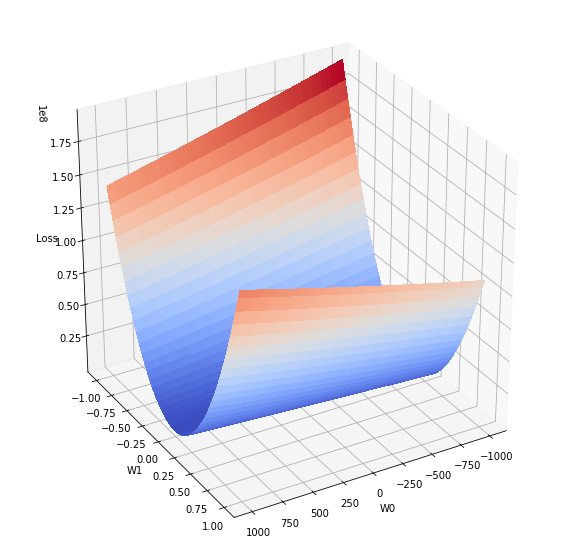

In [161]:
# 가중치 조합 만들기
W0s = np.linspace(-1000,1000,100)
W1s = np.linspace(-1,1,100)

points = np.stack(np.meshgrid(W0s,W1s),axis=-1) # 가중치 조합 만들기
points = points.reshape(-1,2)
points

# 손실 함수값 계산하기
def calculate_MSE(W0, W1):
    X = movie_df.nums_want_to_see # 독립 변수, 보고싶어요 수
    y_true = movie_df.nums_audience # 실제값

    y_pred = W1*X+W0 # 가중치 조합을 통한 예측값
    return ((y_true - y_pred)**2).mean() # MSE

losses = []
for W0, W1 in points:
    loss = calculate_MSE(W0, W1)
    losses.append(loss)
losses = np.array(losses)

# 가중치 별 손실값 확인하기
points_with_loss = np.concatenate([points,
                                   losses.reshape(-1,1)],
                                  axis=1)

loss_df = pd.DataFrame(points_with_loss,columns=['W0','W1','Loss'])

# 가중치 시각화
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

surf_value = loss_df.values.reshape(100,100,3)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X=surf_value[:,:,0],
                       Y=surf_value[:,:,1],
                       Z=surf_value[:,:,2],
                       cmap=cm.coolwarm,
                       linewidth=0,
                       antialiased=False)
ax.view_init(azim=60)
ax.set_xlabel('W0')
ax.set_ylabel('W1')
ax.set_zlabel('Loss')
plt.show()

우리는 최적의 가중치를 계산하기 위해서 총 $W_0$의 케이스 수 100개, $W_1$의 케이스 수 100개로<br>
총 $(W_0,W_1)$의 조합수 10000개를 대입하여 찾았습니다. 

위의 방식(Grid Search)으로 가중치 조합을 찾게 되면 아래와 같은 문제가 발생합니다.

1. 각 가중치 당 케이스 수를 늘리면 연산이 크게 늘어난다.
2. 가중치 종류의 수가 늘어나면 연산이 크게 늘어난다.

$\mbox{손실함수 계산 횟수} = \mbox{가중치 종류의 갯수}^{\mbox{가중치 당 케이스 수}}$

로 폭발적으로 계산이 늘어납니다. 이와 같이 간단한 함수 관계에서는 가능하지만,<br>
훨씬 가중치의갯수가 많고, 데이터 수가 많으면 계산량이 지나치게 많아지게 됩니다.

<br>

## 2. 손실함수가 줄어드는 방향, `Negative Gradient`
---

* 손실함수 위의 한 점$(W_0,W_1) = (-500,-0.75)$을 임의로 잡아보겠습니다.

In [162]:
w0 = -500
w1 = -0.75
mse = calculate_MSE(w0,w1)

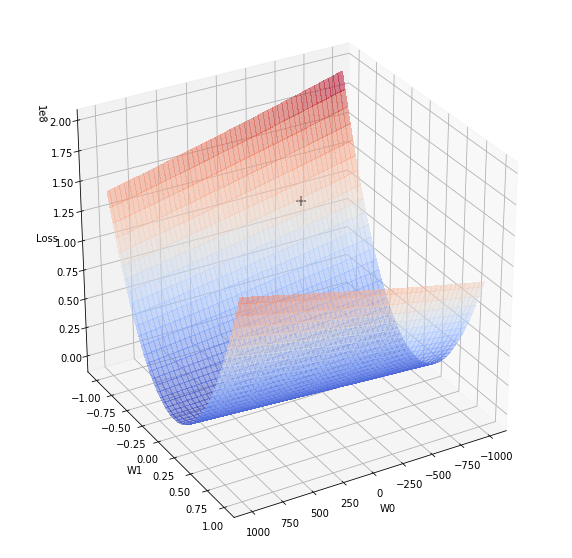

In [163]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.scatter([w0], [w1], [mse], 
           s=100, c='black', marker='+', zorder=-1)

surf = ax.plot_surface(X=surf_value[:,:,0],
                       Y=surf_value[:,:,1],
                       Z=surf_value[:,:,2],
                       cmap=cm.coolwarm,
                       linewidth=0,
                       antialiased=False,
                       alpha=0.5,)
ax.view_init(azim=60)
ax.set_xlabel('W0')
ax.set_ylabel('W1')
ax.set_zlabel('Loss')
plt.show()

우리는 위의 점을 통해, 직관적으로 + 점을 기준으로 <br>
어느 방향으로 값을 바꾸어야 하는지를 알 수 있습니다.<br>
바로 **기울기의 반대 방향**으로 Weight$(W_0,W_1)$의 값을 갱신하면 됩니다.<br>
이와 같이 기울기의 반대 방향으로, 값을 갱신하는 방식을 <br>
Gradient Descent 방식이라 합니다.

<br><br>

# \[ 2. Gradient Descent \]

----

----

> *이전 시간에 배운 Grid Search의 문제에 대해 파악해 봅니다.*<br>

<br>
## 1. 손실함수를 미분하기
---

$$
\mbox{예측함수 : } \hat y = w_1x + w_0\\
\mbox{손실함수 : } Loss(w_0,w_1) = \frac{1}{2m}\sum_{i=1}^{m}(\hat y - y)^2 = \frac{1}{2m}\sum_{i=1}^{m}(w_1x^{(i)}+w_0-y^{(i)})^2
$$

우리는 고등학교 때 배운 미분 함수 식을 다시 떠올려 보겠습니다.

![Imgur](https://i.imgur.com/ZIEgU9L.png)

위의 미분 공식을 통해, 각 Weight들을 미분해 보도록 하겠습니다.

$$
\frac{\partial Loss}{\partial w_0} = \frac{1}{m}\sum_{i=1}^{m}(w_1x^{(i)}+w_0 - y^{(i)})\\
\frac{\partial Loss}{\partial w_1} = \frac{1}{m}\sum_{i=1}^{m}(w_1x^{(i)}+w_0 - y^{(i)})x^{(i)}\\
$$

우리는 위의 미분식을 통해, 각 가중치 위치에서의 기울기를 알 수 있습니다.

In [164]:
# W0에 대한 미분식
def calculate_wo_derivative(w0,w1):
    x = movie_df.nums_want_to_see # 독립 변수, 보고싶어요 수
    y_true = movie_df.nums_audience # 실제값
    return (w1*x + w0 - y_true).mean()

# W1에 대한 미분식
def calculate_w1_derivative(w0,w1):
    x = movie_df.nums_want_to_see # 독립 변수, 보고싶어요 수
    y_true = movie_df.nums_audience # 실제값
    return ((w1*x + w0 - y_true)*x).mean()

In [171]:
w0 = -500
w1 = -0.75
mse = calculate_MSE(w0,w1)
dw0 = calculate_wo_derivative(w0,w1)
dw1 = calculate_w1_derivative(w0,w1)

dw0,dw1

(-10136.0625, -126987182.9375)

## 2. Gradient Descent 적용하기

---


경사하강법은 함수의 기울기(경사)를 구하여, 기울기가 낮은 쪽으로 계속 이동시켜<br>
극값에 이를 때까지 반복시키는 알고리즘입니다.

$$
W_{new} = W_{old} - \alpha * \frac{\partial loss}{\partial W} 
$$

Gradient Descent 알고리즘에서 우리는 두 가지를 결정해야 합니다.

1. 한번에 얼마만큼 갱신할 것인가? (learning Rate)
2. 몇번이나 갱신할 것인가? (Epoch)

### (1) Learning Rate

우리는 Learning Rate($\alpha$)를 통해, 얼마나 갱신될지를 결정할 수 있습니다.<br>
우리의 가중치는 가중치 별로, 갱신해야 하는 크기가 다릅니다.<br>

In [215]:
w0 = -500
w1 = -0.75
mse = calculate_MSE(w0,w1)
dw0 = calculate_wo_derivative(w0,w1)
dw1 = calculate_w1_derivative(w0,w1)

dw0,dw1

(-10136.0625, -126987182.9375)

여기서 dw1은 너무 큰 기울기값을 가지고 있습니다.<br> 
학습율을 0.001이라고 준다면

In [216]:
alpha = 0.001

new_w0 = w0 - alpha * dw0
new_w1 = w1 - alpha * dw1

new_w0, new_w1

(-489.8639375, 126986.43293750001)

In [218]:
# 오히려 손실함수의 값이 더 크게 나타나게 됩니다.
new_mse = calculate_MSE(new_w0,new_w1)

print("갱신하기 전 손실함수 값 : {:.3f}".format(mse))
print("갱신한 후  손실함수 값  : {:.3f}".format(new_mse))

갱신하기 전 손실함수 값 : 108385097.891
갱신한 후  손실함수 값  : 2399480551499843072.000


그래서 적절한 값을 찾아야 하는데 여기서는 
학습율을 $10^{-8}$<br>
로 주겠습니다.

In [278]:
alpha = 2e-8

new_w0 = w0 - alpha * dw0
new_w1 = w1 - alpha * dw1

new_w0, new_w1

(-499.9999893712081, -0.6224069128603048)

In [279]:
new_mse = calculate_MSE(new_w0,new_w1)

print("갱신하기 전 손실함수 값 : {:.3f}".format(mse))
print("갱신한 후  손실함수 값  : {:.3f}".format(new_mse))

갱신하기 전 손실함수 값 : 108385097.891
갱신한 후  손실함수 값  : 78402189.689


너무 작게 준다면, 아래와 같이 손실함수가 거의 줄지 않습니다.<br>
그래서 적절한 수준의 Learning Rate을 설정하는 것이 중요합니다.

In [280]:
alpha = 1e-10

new_w0 = w0 - alpha * dw0
new_w1 = w1 - alpha * dw1

new_w0, new_w1

(-499.99999994685606, -0.7493620345643015)

In [281]:
new_mse = calculate_MSE(new_w0,new_w1)

print("갱신하기 전 손실함수 값 : {:.3f}".format(mse))
print("갱신한 후  손실함수 값  : {:.3f}".format(new_mse))

갱신하기 전 손실함수 값 : 108385097.891
갱신한 후  손실함수 값  : 108223131.584


### (2) Epoch

우리는 데이터 셋 전체를 계산하여 갱신한 횟수를 Epoch이라고 합니다.<br>
우리는 몇 번 갱신할지 정해야 합니다. 이번에는 100번 갱신해보도록 하겠습니다.

In [293]:
# 갱신된 weight와 mse 저장
w0_history = [w0]
w1_history = [w1]
mse_history = [mse]

alpha = 2e-10 # 학습률
epoch = 100 # 몇 번 학습할지 결정

for i in range(epoch):
    # 이전 가중치 가져오기
    old_w0 = w0_history[-1]
    old_w1 = w1_history[-1]
    
    # 미분값 갱신
    dw0 = calculate_wo_derivative(old_w0,old_w1)
    dw1 = calculate_w1_derivative(old_w0,old_w1)
    
    # 경사하강법을 통한 가중치 갱신
    new_w0 = old_w0 - alpha * dw0
    new_w1 = old_w1 - alpha * dw1
    new_mse = calculate_MSE(new_w0,new_w1)
    
    # 결과 저장
    w0_history.append(new_w0)
    w1_history.append(new_w1)
    mse_history.append(new_mse)

## 3. 결과 확인하기

---


In [294]:
hist_df = pd.DataFrame({
    "W0":w0_history,
    "W1":w1_history,
    "Loss":mse_history
})

손실함수의 값이 꾸준히 떨어지는 것을 확인할 수 있습니다.

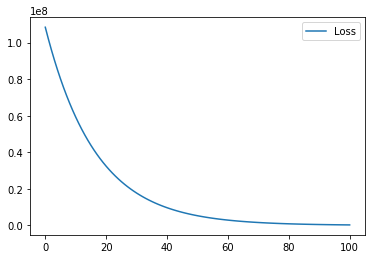

In [295]:
hist_df.plot(y='Loss')
plt.show()

In [296]:
hist_df.sort_values('Loss').iloc[0]

W0        -499.999935
W1           0.061810
Loss    270730.664559
Name: 100, dtype: float64

$(W_0,W_1) = (-500,0.06)$이 나왔습니다.

이를 확인하면 아래와 같습니다

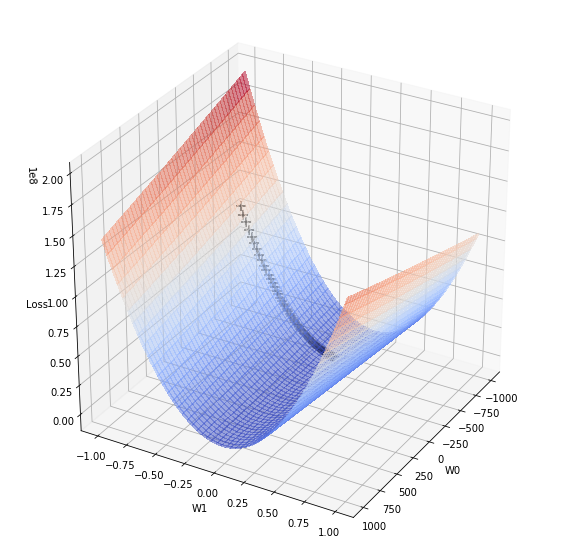

In [297]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.scatter(hist_df.W0, hist_df.W1, hist_df.Loss, 
           s=100, c='black', marker='+', zorder=-1)

surf = ax.plot_surface(X=surf_value[:,:,0],
                       Y=surf_value[:,:,1],
                       Z=surf_value[:,:,2],
                       cmap=cm.coolwarm,
                       linewidth=0,
                       antialiased=False,
                       alpha=0.5,)
ax.view_init(azim=30)
ax.set_xlabel('W0')
ax.set_ylabel('W1')
ax.set_zlabel('Loss')
plt.show()

Grid Search의 경우 우리는 모든 가중치의 조합을 다 탐색했어야 합니다.<br>
Gradient Descent의 경우, 우리는 훨씬 적은 횟수로도<br>
원하는 최적의 값을 가져올 수 있습니다.

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/03/22

---